In [1]:
import tensorflow as tf
import time
import my_colors

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)

In [2]:
import tarfile
import re
import urllib.request
import os
import random

class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

In [3]:
import numpy as np
# Spacy is my favourite nlp framework, which havu builtin word embeddings trains on wikipesia
from spacy.en import English

class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
        self.parser = English()
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [4]:
import itertools

def preprocess_batched_split(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch = []
        labelss = []
        sentence_sizes_batch = []
        for index in range(batch_size):
            text, label = next(iterator)
            sents = [list(y) for x, y in itertools.groupby(text, lambda z: z == '.') if not x]
            sentence_sizes = [len(s) for s in sents]
            text_embed = [embedding(sent) for sent in sents]
            
            batch.append(text_embed)
            labelss.append(label)
            sentence_sizes_batch.append(sentence_sizes)
            
        labels_batch = np.array(labelss, dtype=np.int32)
        sent_per_doc = np.array([len(x) for x in sentence_sizes_batch])
        words_per_sent_per_doc = np.array(sentence_sizes_batch)
        yield np.array(batch), labels_batch, words_per_sent_per_doc, sent_per_doc

In [5]:
import itertools

def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [6]:
reviews = list(ImdbMovieReviews())

In [7]:
random.shuffle(reviews)

In [8]:
#################################################

In [9]:
import HanSequenceLabellingModel
import model_components

%load_ext autoreload
%autoreload 1
#%aimport HanSequenceLabellingModel, model_components
%aimport

Modules to reload:


Modules to skip:



In [10]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=10)

In [11]:
from HanSequenceLabellingModel import HanSequenceLabellingModel

In [12]:
def HAN_model_1(session, restore_only=False):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

In [19]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc,) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        step, summaries, loss, accuracy, _ = s.run([
                model.global_step,
                model.summary,
                model.loss,
                model.accuracy,
                model.train_op,
        ], feed_dict=fd)
        td = time.clock() - t0

        summary_writer.add_summary(summaries, global_step=step)

        checkpoint_frequency = 100
        eval_frequency = 1
        
        if step % 1 == 0:
            print('step %s, loss=%s, accuracy=%s, t=%s, inputs=%s' % (step, loss, accuracy, round(td, 2), fd[model.inputs_embedded].shape))
        if step != 0 and step % checkpoint_frequency == 0:
            print('checkpoint & graph meta')
            checkpoint_path = 'checkpoints/checkpoint'
            saver.save(s, checkpoint_path, global_step=step)
            print('checkpoint done')

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400


InvalidArgumentError: 5 is not between 0 and 4
	 [[Node: train/gradients/sentence_level/sentence/attention/Tensordot/transpose_grad/InvertPermutation = InvertPermutation[T=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](sentence_level/sentence/attention/Tensordot/concat_1)]]
	 [[Node: sentence_level/sentence/attention/Tensordot/Shape/_1777 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_34752_sentence_level/sentence/attention/Tensordot/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'train/gradients/sentence_level/sentence/attention/Tensordot/transpose_grad/InvertPermutation', defined at:
  File "/opt/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-cafc7deabc02>", line 6, in <module>
    model, saver = HAN_model_1(s)
  File "<ipython-input-18-3fd959f4f9c4>", line 27, in HAN_model_1
    is_training=is_training,
  File "/home/katenos/au_dl_course/seminar_9/homework/HanSequenceLabellingModel.py", line 39, in __init__
    self.train_op
  File "/opt/anaconda3/lib/python3.6/site-packages/lazy/lazy.py", line 28, in __get__
    value = self.__func(inst)
  File "/home/katenos/au_dl_course/seminar_9/homework/HanSequenceLabellingModel.py", line 141, in train_op
    tf.gradients(self.loss, tvars),
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 348, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py", line 494, in _TransposeGrad
    return [array_ops.transpose(grad, array_ops.invert_permutation(p)), None]
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1454, in invert_permutation
    result = _op_def_lib.apply_op("InvertPermutation", x=x, name=name)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'sentence_level/sentence/attention/Tensordot/transpose', defined at:
  File "/opt/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 20 identical lines from previous traceback]
  File "<ipython-input-18-3fd959f4f9c4>", line 27, in HAN_model_1
    is_training=is_training,
  File "/home/katenos/au_dl_course/seminar_9/homework/HanSequenceLabellingModel.py", line 37, in __init__
    self.sentence_level_output
  File "/opt/anaconda3/lib/python3.6/site-packages/lazy/lazy.py", line 28, in __get__
    value = self.__func(inst)
  File "/home/katenos/au_dl_course/seminar_9/homework/HanSequenceLabellingModel.py", line 113, in sentence_level_output
    sentence_encoder_output, self.sentence_output_size, scope=scope)
  File "/home/katenos/au_dl_course/seminar_9/homework/model_components.py", line 82, in task_specific_attention
    scope=scope)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1661, in fully_connected
    outputs = layer.apply(inputs)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 503, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 450, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/core.py", line 137, in call
    [0]])
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 2453, in tensordot
    a_reshape, a_free_dims, a_free_dims_static = _tensordot_reshape(a, a_axes)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 2420, in _tensordot_reshape
    reshaped_a = array_ops.reshape(array_ops.transpose(a, perm), new_shape)

InvalidArgumentError (see above for traceback): 5 is not between 0 and 4
	 [[Node: train/gradients/sentence_level/sentence/attention/Tensordot/transpose_grad/InvertPermutation = InvertPermutation[T=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](sentence_level/sentence/attention/Tensordot/concat_1)]]
	 [[Node: sentence_level/sentence/attention/Tensordot/Shape/_1777 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_34752_sentence_level/sentence/attention/Tensordot/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [26]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

from my_colors import print_color, rgb


        
with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())
    
    data, labels_batch, sent_per_doc,\
    words_per_sent_per_doc, sents_batch = next(batches_split)

    fd = {
        model.is_training: True,
        model.inputs_embedded: data,
        model.word_lengths: words_per_sent_per_doc,
        model.sentence_lengths: sent_per_doc,
        model.labels: labels_batch,
        model.sample_weights: np.ones(shape=(10))
    }

    word_weights, sent_weights = s.run([model.word_weights, 
                                              model.sentence_weights], 
                                             feed_dict=fd)
    
    sent_weights = sent_weights[0]
    sents = sents_batch[0]
    
    max_sent_weight = 0
    max_word_weight = 0
    
    for sent_index in range(len(sents)):
        max_sent_weight = max(max_sent_weight, sent_weights[sent_index])
        
        for word_index in range(len(sents[sent_index])):
            max_word_weight = max(max_word_weight, word_weights[sent_index][word_index])
    
    def draw_colored_text(sentences, sent_weights, word_weights):
        print_color("\t", bg=rgb(5, 0, 5.0), end=' ') 
        print_color("\t", bg=rgb(5, 0, 2.5), end=' ')
        print_color("\t", bg=rgb(5, 0, 0.0), end='\n')
        print("min\tmed\tmax")
        for sent_index in range(len(sentences)):
            intensity =  5 - int(sent_weights[sent_index] / max_sent_weight*5)
            print_color("\t", bg=rgb(5, 0, intensity), end=' ') 
            print_color(" ", end=' ') 
            for word_index in range(len(sentences[sent_index])):
                intensity = 5 - int(word_weights[sent_index][word_index] / max_word_weight*5)
                print_color(sentences[sent_index][word_index], bg=rgb(5, 0, intensity), end=' ') 
            print()
    draw_colored_text(sents,  sent_weights, word_weights)
    print()


Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
	 	 	
min	med	max
	   this movie should be shown to film school students as an example of what not to do 
	   the original kicked some major tire squealing butt , this horrible disaster breaks the cardinal rule of bruckheimer films , which is : we all know they suck , but they have great action 
	   this film has no action 
	   this film is boring 
	   where are the cars ? where are the chases ? where s the tension ? where s the suspense ? where s the rush ? where ! ! ? ? this isn t really a movie at all , it s a bad commercial 
	   cars in hours ? that is wrong 
	   they have days to steal them , the ad is wrong 
	   how bad is that ? the leads acting is stiff , wooden and forced 
	   the villain , the cop , the others 
	   who cares 
	   they utter their pointless lines , they serve the illogical plot 
	   they slog through it the best they can as the music 

In [23]:
goods_in_pos = []
goods_in_neg = []
bads_in_pos = []
bads_in_neg = []

def update(status, word, weight):
    def update_pos(word):
        if word == 'good':
            goods_in_pos.append(weight[0])
        else:
            bads_in_pos.append(weight[0])
    def update_neg(word):
        if word == 'good':
            goods_in_neg.append(weight[0])
        else:
            bads_in_neg.append(weight[0])

    update_pos(word) if status else update_neg(word)

In [27]:
tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())
    
    for i, (data, labels_batch, sent_per_doc,\
            words_per_sent_per_doc, sents_batch) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        word_weights, sent_weights = s.run([model.word_weights, 
                                                  model.sentence_weights], 
                                                 feed_dict=fd)

        for review_index in range(len(sents_batch)):
            status = labels_batch[review_index]
            for sent_index in range(len(sents_batch[review_index])):
                for word_index in range(len(sents_batch[review_index][sent_index])):
                    word = sents_batch[review_index][sent_index][word_index]
                    if word == 'good' or word == 'bad':
                        weight = word_weights[review_index * sent_weights.shape[1]][word_index]
                        update(status, word, weight)
        
        print(i, end='\r')
        
        if i == 300:
            break

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400


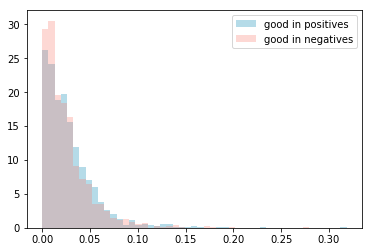

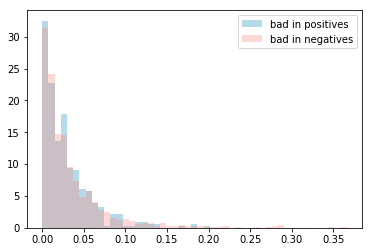

In [28]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
def draw_plot(pos, neg, word):
    max_att = max(max(pos), max(neg))
    bins = np.linspace(0, max_att, 50)   
    
    plt.hist(pos, bins=bins, color='lightblue', 
             alpha=0.9, label='{} in positives'.format(word), 
             normed=True)
    plt.hist(neg, bins=bins, color='salmon', 
             alpha=0.3, label='{} in negatives'.format(word),
             normed=True)
    
    plt.legend(loc='upper right')
    plt.show()
draw_plot(goods_in_pos, goods_in_neg, 'good')
draw_plot(bads_in_pos, bads_in_neg, 'bad')